<a href="https://www.goes-r.gov/">
<img src='./GOES-R_logo_small.png' style="height:150px" align=right alt="National Weather Service">
</a>

# GOES-16: True Color Recipe
__Brian Blaylock__ | _blaylock@gmail.com_ | [_website_](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/home.html) |  
__May 25, 2018__  

This Python notebook shows how to make the GOES-16 True Color product and plot it on different map projections using `pyproj` and `Basemap`. 

The True Color product is an RGB composite image of the following three channels:

|          | Wavelength   | Channel | Description |
|----------|:------------:|:-------:|:-----------:|
| **Red**  | 0.64 &#181;m |    2    | Red Visible |
| **Green**| 0.86 &#181;m |    3    | Veggie Near-IR|
| **Blue** | 0.47 &#181;m |    1    | Blue Visible|


##### Download GOES-16 Data
For this demo, you will first need a GOES-16 data file. You can get GOES-16 files from [NOAA's Amazon S3 GOES Archive](https://aws.amazon.com/public-datasets/goes/). I created a [web interface](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi) to easily download files from the Amazon archive. This example uses the [level 2 _multiband_ formatted file for the _CONUS_ domain](http://home.chpc.utah.edu/~u0553130/Brian_Blaylock/cgi-bin/goes16_download.cgi?domain=C&product=ABI-L2-MCMIP&hour=0). These files contains all 16 bands on the same 2 km resolution grid. Some additional work, not described here, is needed if you want the full 1 km resolution true color images (i.e. need to download three separate files for each RGB channels and subsample the red channel because of its 0.5 km resolution). The multiband formated file makes it easy to utilize all the bands on the same grid. More information about the file can be found on [Amazon AWS](https://docs.opendata.aws/noaa-goes16/cics-readme.html).

----------

The methods shown here are stitched together from the following useful information I found online:
- [ABI Bands Quick Information Guides](https://www.goes-r.gov/education/ABI-bands-quick-info.html)
- [Open Commons Consortium](http://edc.occ-data.org/goes16/python/)
- [GeoNetCast Blog](https://geonetcast.wordpress.com/2017/07/25/geonetclass-manipulating-goes-16-data-with-python-part-vi/)
- [Proj documentation](http://proj4.org/projections/geos.html)
- [Pyproj documentation](http://jswhit.github.io/pyproj/pyproj.Proj-class.html)


### First, import some libraries we will use

In [1]:
%matplotlib inline

from netCDF4 import Dataset
from datetime import datetime, timedelta
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap

# pyproj is used to regrid the data on a Basemap. 
try:
    from pyproj import Proj       
except:
    # Note to self: Since pyproj is not installed on meteo19, load it this way
    import sys
    sys.path.append('/uufs/chpc.utah.edu/sys/pkg/python/2.7.3_rhel6/lib/python2.7/site-packages/')
    from pyproj import Proj

### Open and Read the GOES-16 NetCDF File


In [2]:
# I previously downloaded this file from AWS
C_file = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20180524/OR_ABI-L2-MCMIPC-M3_G16_s20181441732249_e20181441735022_c20181441735136.nc'
C = Dataset(C_file, 'r')

### Image's Date/Time Information

In [3]:
# Seconds since 2000-01-01 12:00:00
add_seconds = C.variables['t'][0]

# Datetime of image scan
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

### True Color Recipe
Since the Veggie channel is not a true visble green, we have to interpolate the value. I followed the instructions [here](http://edc.occ-data.org/goes16/python/) for applying a gamma correction and calculating the "true green" value.

##### Red
- 0.64 &#181;m (Band 2)  
- reflectance range [0-1]
- gamma correction

##### Green
- 0.86 &#181;m (Band 3 )
- reflectance range [0-1]
- gamma correction

##### Blue
- 0.47 &#181;m (Band 1 )
- reflectance range [0-1]
- gamma correction

##### True Green
- 0.48358168xR + 0.45706946xB + 0.06038137xG

In [4]:
# Confirm that each band is the wavelength we are interested in
for b in [2, 3, 1]:
    print "%s is %s %s" % (C.variables['band_wavelength_C%02d' % b].long_name,
                           C.variables['band_wavelength_C%02d' % b][0],
                           C.variables['band_wavelength_C%02d' % b].units)

ABI band 2 central wavelength is 0.64 um
ABI band 3 central wavelength is 0.865 um
ABI band 1 central wavelength is 0.47 um


In [5]:
# Load the RGB arrays
R = C.variables['CMI_C02'][:].data
G = C.variables['CMI_C03'][:].data
B = C.variables['CMI_C01'][:].data

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
R = np.minimum(R, 1)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

### Simple Image
Use `imshow` to get a simple look at the RGB image we created

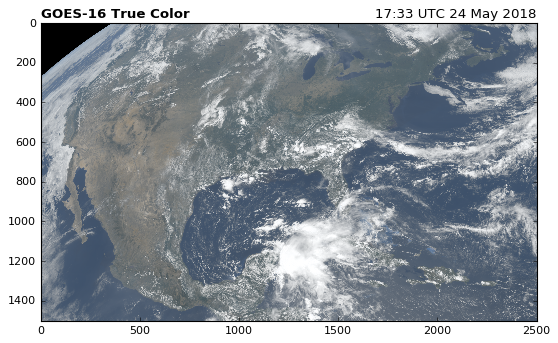

In [6]:
plt.figure(figsize=[8, 8])
plt.imshow(RGB)

plt.title('GOES-16 True Color', fontweight='semibold', loc='left', fontsize=12)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

### Plot on a Basemap: Geostationay Projection
The problem with the above image is that it is not georeferenced. We do not know where in the world each pixel lies. The GOES-16 file contains all the metadata needed to understand the map projection of the image. We will use this data to plot the image on a basemap. The image is in a [geostationary projection](http://proj4.org/projections/geos.html).

In [7]:
C.variables['goes_imager_projection']

<type 'netCDF4._netCDF4.Variable'>
int32 goes_imager_projection()
    long_name: GOES-R ABI fixed grid projection
    grid_mapping_name: geostationary
    perspective_point_height: 35786023.0
    semi_major_axis: 6378137.0
    semi_minor_axis: 6356752.31414
    inverse_flattening: 298.2572221
    latitude_of_projection_origin: 0.0
    longitude_of_projection_origin: -75.0
    sweep_angle_axis: x
unlimited dimensions: 
current shape = ()
filling on, default _FillValue of -2147483647 used

In [8]:
# Satellite height
sat_h = C.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = C.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = C.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = C.variables['x'][:] * sat_h
Y = C.variables['y'][:] * sat_h

In [9]:
# The geostationary projection is perhaps the easiest way to plot the image on a map.
# Essentially, we are stretching the image across a map with the same projection and dimensions.
m = Basemap(projection='geos', lon_0=sat_lon,
            resolution='i', area_thresh=5000,
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())

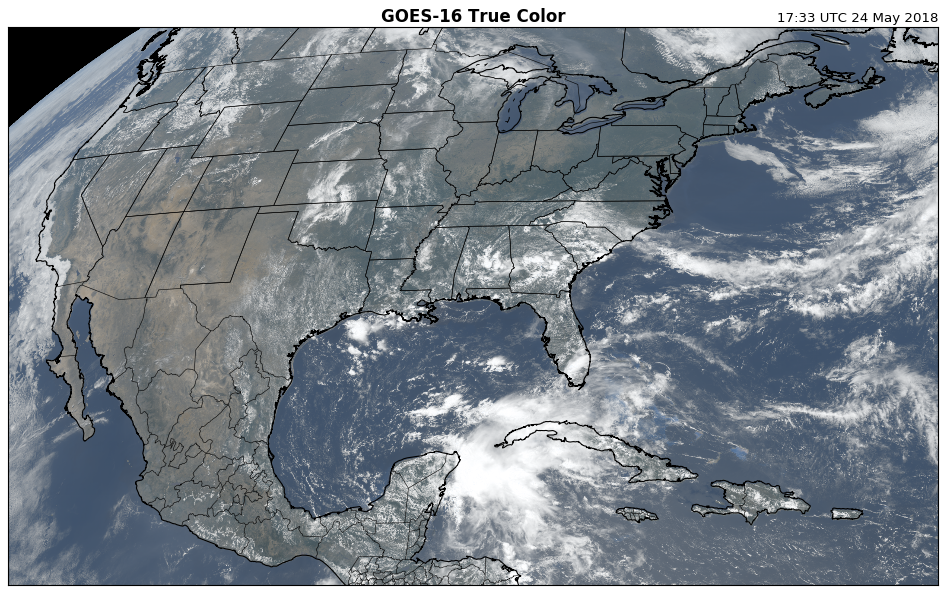

In [10]:
plt.figure(figsize=[15, 12])
m.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

### What about for other projections?

The data pixels are still not georeferences. We will use the metadata and `pyproj` to calculate the latitude and longitude of each pixel so we can project the image onto other maps. This is done by using an inverse transformation of the map projection object, `p`, of the map coordinates given by X and Y. Since the satellite doesn't move, you can do this calculation once and save the latitude and longitude arrays for later use. I have saved these arrays in an HDF5 file [here](https://pando-rgw01.chpc.utah.edu/GOES16/goes16_conus_latlon_east.h5) you may use.

#### The magic function: `pyproj.Proj`
This function creates a map projection object of the geostationary projection.

In [11]:
# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

In [12]:
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

lats[np.isnan(R)] = np.nan
lons[np.isnan(R)] = np.nan
# ^ Please take a moment and appreciate those two lines. Before adding this seemingly simple and unimportant step,
#   the plots were getting messed up. I contemplated why that was happening during a 2-hr commute home, while cooking
#   dinner, watching an hour of Gone With the Wind with my wife, and while sleeping for 7 hours. At breakfast I figured
#   it out! I had to mask the empty data with nans like I did with the RGB values. During the first 2 minutes of work,
#   I added these two lines and now everything from here on down works!

 ### Plot on a Basemap: Lambert Conformal Projection
 I am going to project the GOES-16 data on the Lambert Conformal Projection used by the [HRRR](https://rapidrefresh.noaa.gov/hrrr/) model.

In [13]:
# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=5000, \
             width=1800*3000, height=1060*3000, \
             lat_1=38.5, lat_2=38.5, \
             lat_0=38.5, lon_0=-97.5)

We can't simply plot the reprojected image with `imshow` because the pixels are spaced irregularly. We have to use `pcolormesh`, which is not a trivial task. We need to create a color tuple for each pixel. Details on doing this are on stackoverflow [here](https://stackoverflow.com/questions/29232439/plotting-an-irregularly-spaced-rgb-image-in-python) and [here](https://stackoverflow.com/questions/41389335/how-to-plot-geolocated-rgb-data-faster-using-python-basemap). Below is my method.

In [14]:
# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster, according to stackoverflow. Not sure why.

/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/colors.py:405: RuntimeWarning: invalid value encountered in greater
  if (c.ravel() > 1).any() or (c.ravel() < 0).any():
/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/matplotlib-1.5.1-py2.7-linux-x86_64.egg/matplotlib/colors.py:405: RuntimeWarning: invalid value encountered in less
  if (c.ravel() > 1).any() or (c.ravel() < 0).any():


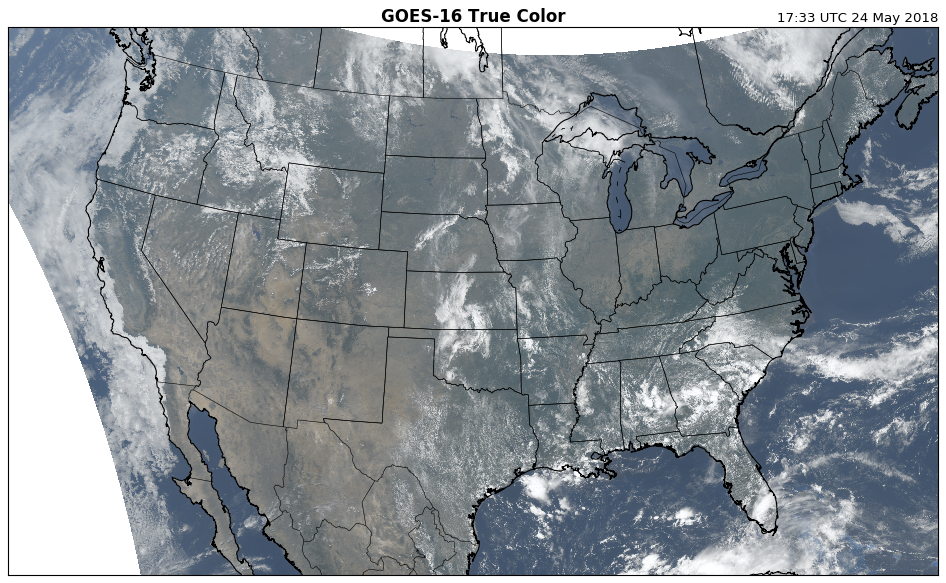

In [15]:
# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[15, 12])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # without this line the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mH.drawcoastlines()
mH.drawcountries()
mH.drawstates()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

Wa-la! You have just projected the GOES-16 data on the HRRR map projection and domain :)

--------

 ### Plot on a Basemap: Cylindrical Projection
 It is also possible to zoom in on a specific location. This shows a True Color image for over Northern Utah

In [16]:
# Location of Utah
l = {'latitude': 39.75,
     'longitude': -111.5}

# Draw zoomed map
mZ = Basemap(resolution='i', projection='cyl', area_thresh=50000,\
             llcrnrlon=l['longitude']-3.25, llcrnrlat=l['latitude']-3.25,\
             urcrnrlon=l['longitude']+3.25, urcrnrlat=l['latitude']+3.25,)

/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:4726: RuntimeWarning: invalid value encountered in greater
  lonsin1 = np.where(lonsin1 > lon_0+180, lonsin1-360 ,lonsin1)
/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:4727: RuntimeWarning: invalid value encountered in less
  lonsin1 = np.where(lonsin1 < lon_0-180, lonsin1+360 ,lonsin1)
/uufs/chpc.utah.edu/sys/installdir/python/2.7.11-c7/lib/python2.7/site-packages/mpl_toolkits/basemap/__init__.py:4731: RuntimeWarning: invalid value encountered in greater_equal
  itemindex = nlons-np.where(londiff>=thresh)[0]


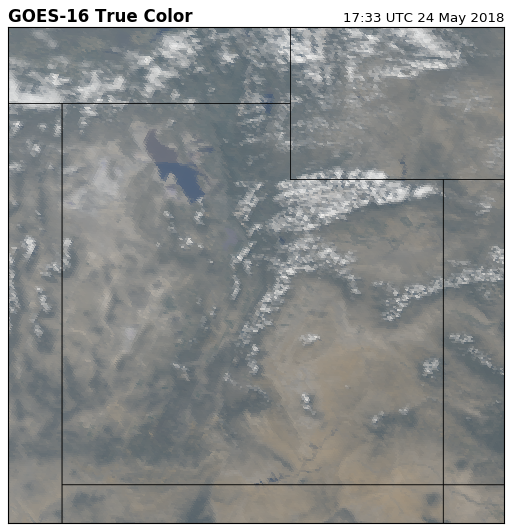

In [17]:
# Now we can plot the GOES data on a zoomed in map centered Utah
plt.figure(figsize=[8, 8])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mZ.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # without this line, the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mZ.drawcoastlines()
mZ.drawcountries()
mZ.drawstates()

plt.title('GOES-16 True Color', fontweight='semibold', loc='left', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

---
# Overlay Nighttime IR when dark
At nighttime, the visible wavlengths don't measure anything. The area is black. But there is still information from the satellite and we can still see clouds at night. To overcome this, we can plot the True Color Image with the Clean IR on top. 

_**First, open the file and do normal stuff for true color image**_

In [18]:
half_night_scan = '/uufs/chpc.utah.edu/common/home/horel-group7/Pando/GOES16/ABI-L2-MCMIPC/20180525/OR_ABI-L2-MCMIPC-M3_G16_s20181450027251_e20181450030024_c20181450030129.nc'
Cnight = Dataset(half_night_scan, 'r')

# Load the RGB arrays
R = Cnight.variables['CMI_C02'][:].data
G = Cnight.variables['CMI_C03'][:].data
B = Cnight.variables['CMI_C01'][:].data

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
R = np.minimum(R, 1)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

_**Load the Clear IR (Band 13) which is 10.3 um**_  
Clean IR has units of Kelvin, so we need to normalize the temperature array between a range of values.

In [19]:
cleanIR = Cnight.variables['CMI_C13'][:].data
cleanIR[cleanIR==-1] = np.nan

# Apply range limits for clean IR channel
cleanIR = np.maximum(cleanIR, 90)
cleanIR = np.minimum(cleanIR, 313)

# Normalize the channel between a range
cleanIR = (cleanIR-90)/(313-90)

# Invert colors
cleanIR = 1 - cleanIR

# Lessen the brightness of the coldest clouds so they don't appear so bright near the day/night line
cleanIR = cleanIR/1.5

##### Show the True Color and the clean IR images
We want to overlay these so the clean IR will fill in the black area on the True Color image

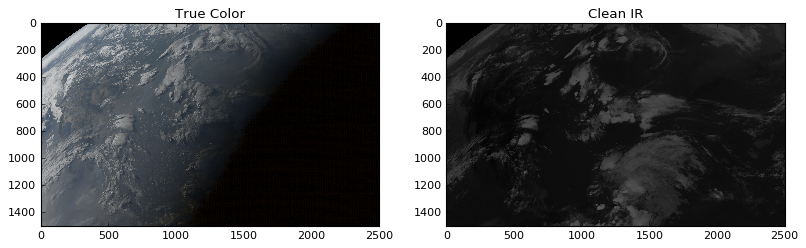

In [20]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(12,4))
ax1.imshow(np.dstack([R, G_true, B]))
ax2.imshow(np.dstack([cleanIR, cleanIR, cleanIR]))
ax1.set_title('True Color')
ax2.set_title('Clean IR')

To fill in the black area on the True Color image we will set the RGB channel to equal the maximum value between the visible channels and the IR channels. This requies a bit of interpretation beucase if the Clean IR has bright clouds in the daylight, they will replace the color values in the true color image. Still, it makes a nice plot and allows you to see clouds when it is nightime. That is why we lessened the brightness of the cleanIR by dividing the values by 1.5 in the lines above.

In [21]:
RGB_IR = np.dstack([np.maximum(R, cleanIR), np.maximum(G_true, cleanIR), np.maximum(B, cleanIR)])

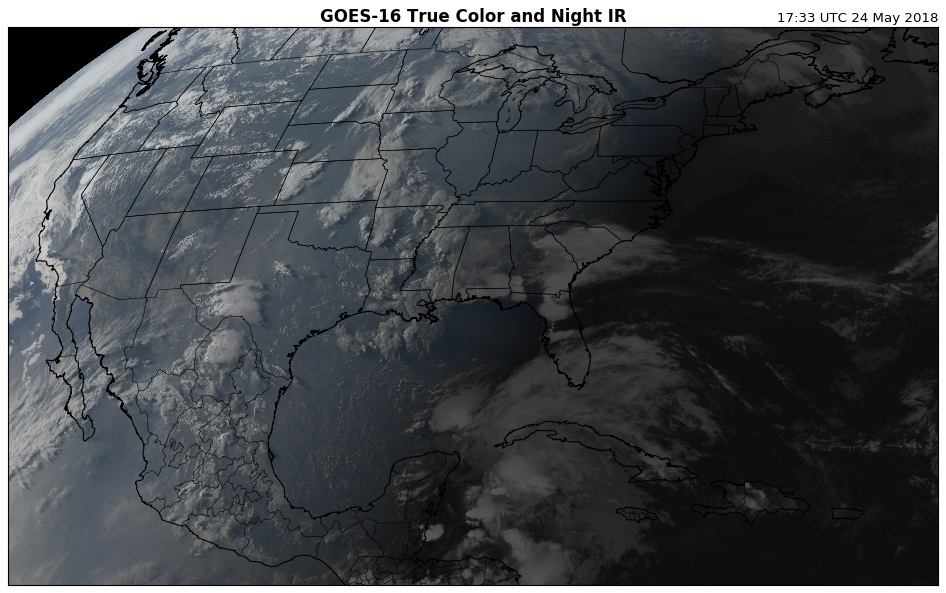

In [22]:
plt.figure(figsize=[15, 12])
m.imshow(np.flipud(RGB_IR)) # Remember, "images" are upside down, so flip up/down
m.drawcoastlines()
m.drawcountries()
m.drawstates()

plt.title('GOES-16 True Color and Night IR', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

---
# Adjust Image Contrast
You can make the colors pop out more if you adjust the image contrast.

Note: you should adjust the contrast _before_ you add in the Clean IR channel.

In [23]:
def contrast_correction(color, contrast):
    """
    Modify the contrast of an R, G, or B color channel
    See: #www.dfstudios.co.uk/articles/programming/image-programming-algorithms/image-processing-algorithms-part-5-contrast-adjustment/

    Input:
        C - contrast level
    """
    F = (259*(contrast + 255))/(255.*259-contrast)
    COLOR = F*(color-.5)+.5
    COLOR = np.minimum(COLOR, 1)
    COLOR = np.maximum(COLOR, 0)
    return COLOR

# Modify the RGB color contrast:
contrast = 125

RGB_contrast = contrast_correction(np.dstack([R, G_true, B]), contrast)
RGB_contrast_IR = np.dstack([np.maximum(RGB_contrast[:,:,0], cleanIR), np.maximum(RGB_contrast[:,:,1], cleanIR), np.maximum(RGB_contrast[:,:,2], cleanIR)])

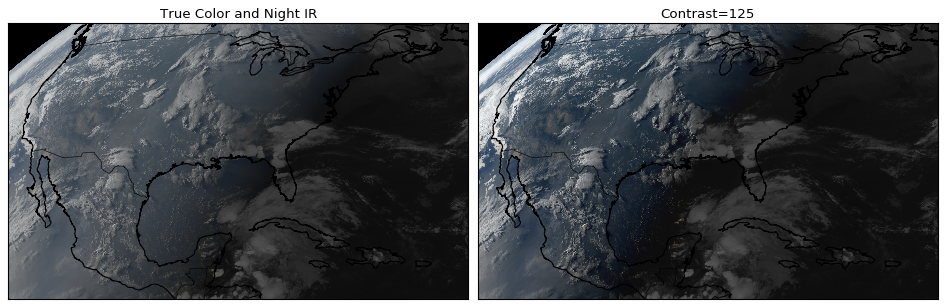

In [24]:
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(15,12))
plt.sca(ax1)
m.imshow(np.flipud(RGB_IR))
m.drawcoastlines()
m.drawcountries()
plt.title('True Color and Night IR')

plt.sca(ax2)
m.imshow(np.flipud(RGB_contrast_IR))
m.drawcoastlines()
m.drawcountries()
plt.title('Contrast=%s' % contrast)

plt.subplots_adjust(wspace=.02)

----

---
# GOES-16 with HRRR Overlay
Ultimately, I wanted to overlay HRRR analyses over the GOES-16 images. I don't show how I got the HRRR data here, but below is a sample image of HRRR simulated reflectivity and 500 mb heights on September 10, 2017 at 1800 UTC. (If you are interestd in HRRR data, see here: http://hrrr.chpc.utah.edu/)

In [25]:
import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2/')
from BB_downloads.HRRR_S3 import get_hrrr_variable
H = get_hrrr_variable(DATE, 'REFC:entire', verbose=False)
H500 = get_hrrr_variable(DATE, 'HGT:500 mb', verbose=False)

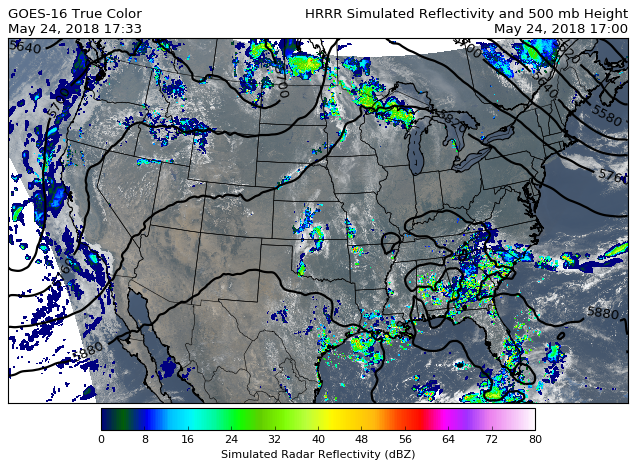

In [26]:
# Mask points with no reflectivity
dBZ = H['value']
dBZ = np.ma.array(dBZ)
dBZ[dBZ == -10] = np.ma.masked

plt.figure(figsize=[10,8])
# Plot the GOES image
newmap = mH.pcolormesh(lons, lats, R, color=colorTuple, linewidth=0, latlon=True)
newmap.set_array(None) # without this, the linewidth is set to zero, but the RGB color is ignored

# Plot the HRRR reflectivity
mH.pcolormesh(H['lon'], H['lat'], dBZ, latlon=True,
              cmap='gist_ncar',
              vmax=80, vmin=0)
cb = plt.colorbar(orientation='horizontal', shrink=.7, pad=.01)
cb.set_label('Simulated Radar Reflectivity (dBZ)')

# Plot the HRRR 500 mb height
cs = mH.contour(H500['lon'], H500['lat'], H500['value'], latlon=True,
                colors='k',
                linewidths=2,
                levels=range(4980, 6100, 60))
plt.clabel(cs, fmt = '%1.0f', fontsize=12)

# Plot other map elements
mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

# Title
date_fmt = '%B %d, %Y %H:%M'
plt.title('GOES-16 True Color\n%s' % DATE.strftime(date_fmt), loc='left')
plt.title('HRRR Simulated Reflectivity and 500 mb Height\n%s' % H['valid'].strftime(date_fmt), loc='right')

# Can we make plots for a Mesoscale scan?
Yes. Yes we can.

In [27]:
# M1 is for the Mesoscale1 NetCDF file
M1_file = 'OR_ABI-L2-MCMIPM1-M3_G16_s20172531800245_e20172531800302_c20172531800373.nc'
M1 = Dataset(M1_file, 'r')

# Load the RGB arrays
R = M1.variables['CMI_C02'][:]
G = M1.variables['CMI_C03'][:]
B = M1.variables['CMI_C01'][:]

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
R = np.minimum(R, 1)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])

# Seconds since 2000-01-01 12:00:00
add_seconds = M1.variables['t'][0]
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Satellite height
sat_h = M1.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = M1.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = M1.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = M1.variables['x'][:] * sat_h
Y = M1.variables['y'][:] * sat_h

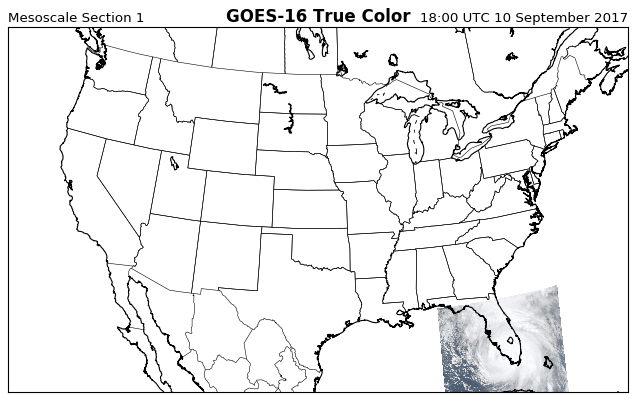

In [28]:
# Plot on HRRR domain:

# map object with pyproj
p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)

# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)
lons, lats = p(XX, YY, inverse=True)

# Make a new map object for the HRRR model domain map projection
mH = Basemap(resolution='i', projection='lcc', area_thresh=1500, \
            width=1800*3000, height=1060*3000, \
            lat_1=38.5, lat_2=38.5, \
            lat_0=38.5, lon_0=-97.5)

xH, yH = mH(lons, lats)

# Create a color tuple for pcolormesh
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster?? according to stackoverflow.

# Now we can plot the GOES data on the HRRR map domain and projection
plt.figure(figsize=[10, 8])

# The values of R are ignored becuase we plot the color in colorTuple, but pcolormesh still needs its shape.
newmap = mH.pcolormesh(xH, yH, R, color=colorTuple, linewidth=0)
newmap.set_array(None) # without this line, the linewidth is set to zero, but the RGB colorTuple is ignored. I don't know why.

mH.drawstates()
mH.drawcountries()
mH.drawcoastlines()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15)
plt.title('%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')
plt.title('Mesoscale Section 1', loc='left')

In [29]:
# The geostationary projection
mM1 = Basemap(projection='geos', lon_0=sat_lon, resolution='i',
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())

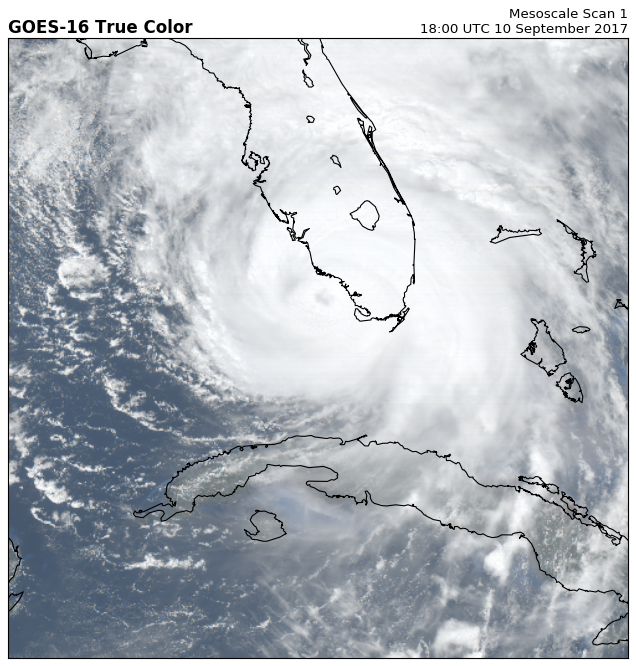

In [30]:
plt.figure(figsize=[10, 10])
mM1.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
mM1.drawcoastlines()
mM1.drawcountries()
mM1.drawstates()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15, loc='left')
plt.title('Mesoscale Scan 1\n%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

----

# Can we do this for a Full Disk Scan? It's possible...
but data files are so large, plotting anythig is very slow. I don't need to do this, so I wont worry about it.

In [31]:
# F is for the Full Disk NetCDF file
F_file = 'OR_ABI-L2-MCMIPF-M3_G16_s20172531745358_e20172531756131_c20172531756202.nc'
F = Dataset(F_file, 'r')

# Load the RGB arrays
R = F.variables['CMI_C02'][:].data
G = F.variables['CMI_C03'][:].data
B = F.variables['CMI_C01'][:].data

# Turn empty values into nans
R[R==-1] = np.nan
G[G==-1] = np.nan
B[B==-1] = np.nan

# Apply range limits for each channel becuase RGB values must be between 0 and 1
R = np.maximum(R, 0)
R = np.minimum(R, 1)
G = np.maximum(G, 0)
G = np.minimum(G, 1)
B = np.maximum(B, 0)
B = np.minimum(B, 1)

# Apply the gamma correction
gamma = 0.4
R = np.power(R, gamma)
G = np.power(G, gamma)
B = np.power(B, gamma)

# Calculate the "True" Green
G_true = 0.48358168 * R + 0.45706946 * B + 0.06038137 * G
G_true = np.maximum(G_true, 0)
G_true = np.minimum(G_true, 1)

# The final RGB array :)
RGB = np.dstack([R, G_true, B])


In [32]:
# Seconds since 2000-01-01 12:00:00
add_seconds = F.variables['t'][0]
DATE = datetime(2000, 1, 1, 12) + timedelta(seconds=add_seconds)

# Satellite height
sat_h = F.variables['goes_imager_projection'].perspective_point_height

# Satellite longitude
sat_lon = F.variables['goes_imager_projection'].longitude_of_projection_origin

# Satellite sweep
sat_sweep = F.variables['goes_imager_projection'].sweep_angle_axis

# The projection x and y coordinates equals
# the scanning angle (in radians) multiplied by the satellite height (http://proj4.org/projections/geos.html)
X = F.variables['x'][:] * sat_h
Y = F.variables['y'][:] * sat_h

##### Geostationary projection is easy

In [33]:
# The geostationary projection
mF = Basemap(projection='geos', lon_0='-89.5',
            llcrnrx=X.min(),llcrnry=Y.min(),
            urcrnrx=X.max(),urcrnry=Y.max())

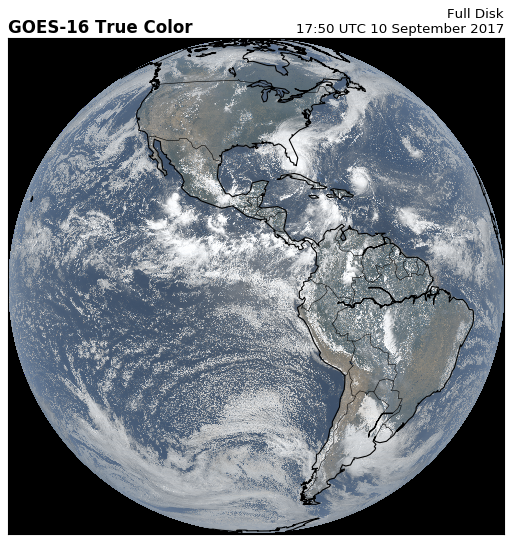

In [34]:
plt.figure(figsize=[10, 8])
mF.imshow(np.flipud(RGB)) # Remember, "images" are upside down, so flip up/down
mF.drawcoastlines()
mF.drawcountries()

plt.title('GOES-16 True Color', fontweight='semibold', fontsize=15, loc='left')
plt.title('Full Disk\n%s' % DATE.strftime('%H:%M UTC %d %B %Y'), loc='right')

##### Calculating latitude and longitude of each point is easy with `pyproj`
Remember you need to mask out the black spaces, so replace with nans.

In [35]:
# Convert map points to latitude and longitude with the magic provided by Pyproj
XX, YY = np.meshgrid(X, Y)

p = Proj(proj='geos', h=sat_h, lon_0=sat_lon, sweep=sat_sweep)
lons, lats = p(XX, YY, inverse=True)

lats[np.isnan(R)] = np.nan
lons[np.isnan(R)] = np.nan
# ^ Please take a moment and appreciate those two lines. Before adding this seemingly simple and unimportant step,
#   the plots were getting messed up. I contemplated why that was happening during a 2-hr commute home, while cooking
#   dinner, watching an hour of Gone With the Wind with my wife, and while sleeping for 7 hours. At breakfast I figured
#   it out! I had to mask the empty data with nans like I did with the RGB values. During the first 2 minutes of work,
#   I added these two lines and now everything from here on down works!

In [36]:
# Create a color tuple for pcolormesh
## !! I had to remove the -1 in the line below to get the shape right. I don't know why.
rgb = RGB[:,:-1,:] # Using one less column is very imporant, else your image will be scrambled! (This is the stange nature of pcolormesh)
colorTuple = rgb.reshape((rgb.shape[0] * rgb.shape[1]), 3) # flatten array, becuase that's what pcolormesh wants.
colorTuple = np.insert(colorTuple, 3, 1.0, axis=1) # adding an alpha channel will plot faster?? according to stackoverflow.

## !! Beyond this step, I haven't been too successful. Lack of memory ??

-------